/var/folders/rf/mrtbxhpn4tqdglcfpw6yhb4w0000gn/T/ipykernel_83831/2908415151.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_rt = reproduction_rate_filtered.resample('M').mean()['reproduction_rate']
/var/folders/rf/mrtbxhpn4tqdglcfpw6yhb4w0000gn/T/ipykernel_83831/2908415151.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_positive_rate = reproduction_rate_filtered.resample('M').mean()['positive_rate']
/var/folders/rf/mrtbxhpn4tqdglcfpw6yhb4w0000gn/T/ipykernel_83831/2908415151.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_cases = reproduction_rate_filtered['new_cases'].resample('M').sum()
/var/folders/rf/mrtbxhpn4tqdglcfpw6yhb4w0000gn/T/ipykernel_83831/2908415151.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_hospitali

            Positive Rate  Reproduction Rate  Hospitalization Rate  \
date                                                                 
2020-09-30       0.030000           1.110000          0.000000e+00   
2020-10-31       0.032903           1.287097          5.361176e+06   
2020-11-30       0.088667           1.146000          1.286617e+07   
2020-12-31       0.045806           0.807742          1.491275e+07   
2021-01-31       0.023548           0.986452          1.872740e+07   
2021-02-28       0.031429           1.197143          1.955545e+07   
2021-03-31       0.053226           1.138710          2.271455e+07   
2021-04-30       0.053333           0.991333          2.627625e+07   
2021-05-31       0.042581           0.914194          2.603530e+07   
2021-06-30       0.018667           0.825000          1.407857e+07   
2021-07-31       0.031935           1.326452          8.172727e+06   
2021-08-31       0.035484           1.038065          2.209173e+07   
2021-09-30       0.0

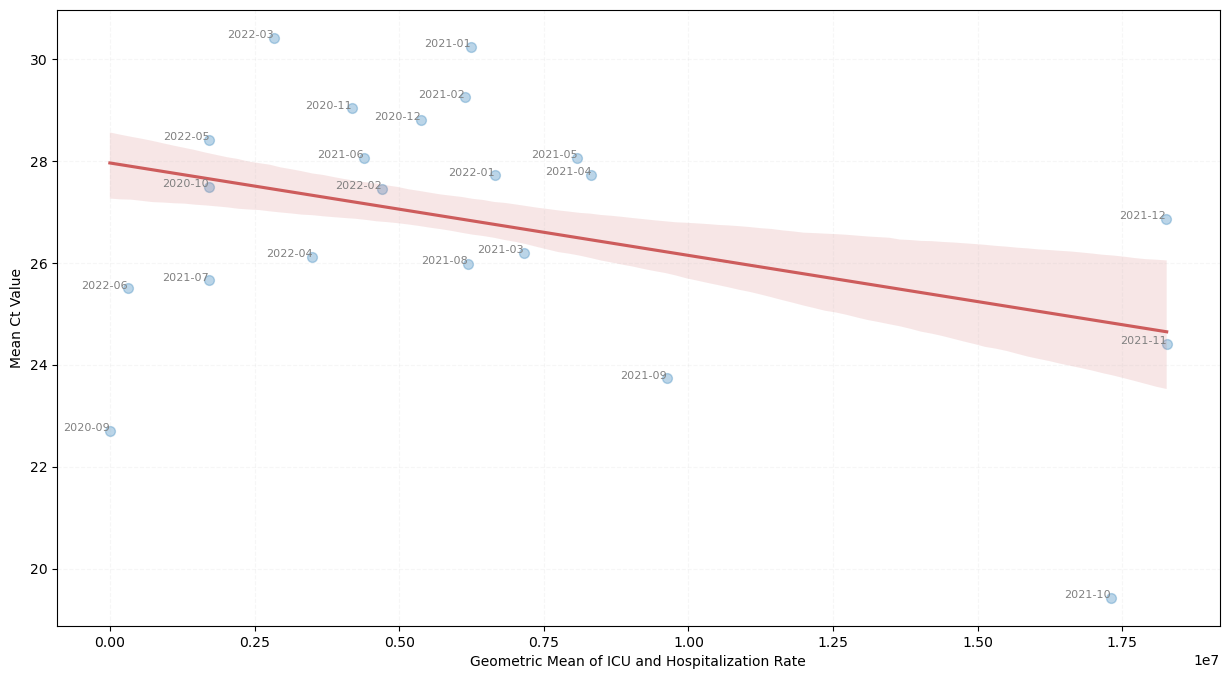

NameError: name 'variant_periods' is not defined

In [18]:
# Load necessary libraries
import os
import pandas as pd
from scipy.stats import gmean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Define file paths
reproduction_rate_path = os.path.join(os.path.expanduser("~"), "Desktop", "paper_host_dynamics", "owid-covid-data.xlsx")
ct_data_path = os.path.join(os.path.expanduser("~"), "Desktop", "dedomena", "ΘΕΤΙΚΑ.xlsx")

# Load data
reproduction_rate_df = pd.read_excel(reproduction_rate_path)
ct_data_df = pd.read_excel(ct_data_path)

# Convert 'date' columns to datetime format
reproduction_rate_df['date'] = pd.to_datetime(reproduction_rate_df['date'])
ct_data_df['date'] = pd.to_datetime(ct_data_df['date'])

# Filter data within desired date range
reproduction_rate_filtered = reproduction_rate_df[(reproduction_rate_df['date'] >= '2020-09-30') & (reproduction_rate_df['date'] <= '2022-06-06')]
reproduction_rate_filtered.set_index('date', inplace=True)

# Calculate monthly averages for Reproduction Rate and Positive Rate
monthly_rt = reproduction_rate_filtered.resample('M').mean()['reproduction_rate']
monthly_positive_rate = reproduction_rate_filtered.resample('M').mean()['positive_rate']

# Calculate monthly hospitalization rate
monthly_cases = reproduction_rate_filtered['new_cases'].resample('M').sum()
monthly_hospitalizations = reproduction_rate_filtered['weekly_hosp_admissions'].resample('M').sum()
monthly_hospitalization_rate = (monthly_hospitalizations / monthly_positive_rate) * 100  # Hospitalization Rate as a percentage

# ICU hospitalization rate
monthly_icu_hospitalizations = reproduction_rate_filtered['weekly_icu_admissions'].resample('M').sum()
monthly_icu_hospitalization_rate = (monthly_icu_hospitalizations / monthly_positive_rate) * 100  # ICU Hospitalization Rate as a percentage

# Filter and group Ct data by month, converting to numeric type
ct_data_filtered = ct_data_df[(ct_data_df['date'] >= '2020-09-30') & (ct_data_df['date'] <= '2022-06-06')]
ct_data_filtered['ct'] = pd.to_numeric(ct_data_filtered['ct'], errors='coerce')
ct_data_filtered.set_index('date', inplace=True)
monthly_ct_mean = ct_data_filtered['ct'].resample('M').mean()

# Create DataFrame and calculate geometric mean including Hospitalization Rate
monthly_data = pd.DataFrame({
    'Positive Rate': monthly_positive_rate,
    'Reproduction Rate': monthly_rt,
    'Hospitalization Rate': monthly_hospitalization_rate,
    "Icu Rate": monthly_icu_hospitalization_rate,
    'Mean Ct': monthly_ct_mean
}).dropna()

# Calculate Geometric Mean for each month
monthly_data['Geometric Mean'] = monthly_data.apply(lambda row: gmean([ row["Icu Rate"], row['Hospitalization Rate']]), axis=1)

# Display the results
print(monthly_data[['Positive Rate', 'Reproduction Rate', 'Hospitalization Rate', 'Icu Rate', 'Geometric Mean']])

# Plot Geometric Mean vs. Mean Ct with correlation information
plt.figure(figsize=(15, 8))
sns.regplot(x='Geometric Mean', y='Mean Ct', data=monthly_data, scatter_kws={'s': 50, 'alpha': 0.3}, line_kws={'color': 'indianred'},ci=50)
plt.title('')
plt.xlabel('Geometric Mean of ICU and Hospitalization Rate')
plt.ylabel('Mean Ct Value')

# Annotate each point with the corresponding date
for i, (x, y) in enumerate(zip(monthly_data['Geometric Mean'], monthly_data['Mean Ct'])):
    plt.text(x, y, monthly_data.index[i].strftime('%Y-%m'), fontsize=8, ha='right', color='gray')

# Display correlation information on the plot
plt.grid(True, linestyle='--', alpha=0.1)
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "phd", "FIG6.png")

plt.savefig(file_path, bbox_inches='tight', dpi=1200)

plt.show()


from scipy.stats import gmean

# Calculate geometric mean for each period
geometric_means = {}
for variant, (start_date, end_date) in variant_periods.items():
    period_data = monthly_data[(monthly_data.index >= start_date) & (monthly_data.index <= end_date)]
    if not period_data.empty:
        # Calculate the geometric mean across the columns 'Icu Rate' and 'Hospitalization Rate'
        geometric_means[variant] = gmean(period_data[['Icu Rate', 'Hospitalization Rate']].mean())

# Convert to DataFrame
geometric_means_df = pd.DataFrame.from_dict(geometric_means, orient='index', columns=['Geometric Mean'])
print(geometric_means_df)

